(chap:18-adas-2)=
# 定量的マクロ経済分析：Part 2

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [47]:
import japanize_matplotlib
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

# numpy v1の表示を使用
np.set_printoptions(legacy='1.21')
# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

## はじめに

前章で展開したADASモデルは次の２つの均衡式で与えられる。

$$
p_{t}=hp_{t-1}+h\left(a u_{t}+v_{t}\right)
$$ (eq:18-eq-p-2)

$$
y_t = -chp_{t-1} + h(u_t-cv_t)
$$ (eq:18-eq-y-2)

ここで

$$
h\equiv\frac{1}{1+a c}<1,
$$ (eq:18-h-2)

* $p_t$：価格水準のトレンドからの％乖離
* $y_t$：産出量のトレンドからの％乖離
* $v_t\sim N\left(0,\sigma_v^2\right)$：総供給ショック
* $u_t\sim N\left(0,\sigma_u^2\right)$：総需要ショック

またカリブレーションの手法を使い，次の値を設定した。

In [48]:
ahat = 0.4405822671569939
chat = 0.5002776200207564
u_std = 0.01475683470914417
v_std = 0.007494205944060558

In [50]:
print(f'aの値：{ahat:.3f}')
print(f'cの値：{chat:.3f}')
print(f'uの標準偏差：{u_std:.6f}')
print(f'vの標準偏差：{v_std:.6f}')

aの値：0.441
cの値：0.500
uの標準偏差：0.014757
vの標準偏差：0.007494


これらの値を使い，次の定量的マクロ分析をおこなう。第一に，ADASモデルの安定性を検討する。ADASモデルの定性的分析をとおして長期的な均衡は安定的だと直感的に理解できるが，以下では，差分方程式を使い結果をプロットし均衡の安定性を確認する。これにより，均衡への収束の速さを視覚的に確認することも可能となる。第二に，インパルス反応関数を使い，需要ショックもしくは供給ショックが発生した際，産出量と物価水準（トレンドからの％乖離）がどのように変化するかを示す時系列的なプロットに基づき検討する。このような定量分析は，ADASモデルの定性的な理解を補完することになる。第三に，確率的シミュレーションをおこない，ADASモデルが景気循環データをどの程度再現できるかが焦点となる。確率的シミュレーションでは，毎期毎期，総需要・総供給ショックが絶え間なく発生する状況を考え，生成されるデータと実際の景気循環データの特徴を比較することにより，ADASモデルのデータ再現力を評価することができる。第四に，確率的シミュレーションの結果を踏まえて，次の定量的な問いを検討する。
> GDPと価格水準の長期トレンドからの乖離（％）の変動は，何パーセントが需要ショックにより引き起こされ，何パーセントが供給ショックに起因するのか？

## コードの基本形

以下ではシミュレーションをおこなうが，コードは関数にまとめて書くことにする。
コードは次のようなパターンになっている。

関数の中身
1. アップデート用の変数を用意
1. 空のリストを作成
1. `for`ループに`.append()`を使う
1. `DataFrame`を返す

簡単な例として次の差分方程式を考えてみよう。

$$
x_t = x_{t-1} + a
$$

`my_func()`は，この差分方程式を使った計算結果を`DataFrame`として返す。

In [4]:
def my_func(x0, a, n):
    """
    引数：
        x0: 初期値
        a: 差分方程式のパラメーター
        n: ループ計算の回数
    戻り値：
        DataFrame
    """

    x = x0      # アップデート用の変数

    lst = [x]   # 空のリスト

    for i in range(n):

        x = x + a      # 差分方程式

        lst.append(x)  # リストに結果を追加
        
    return pd.DataFrame({'col': lst})

In [5]:
my_func(0, 10, 5)

,col
0,0
1,10
2,20
3,30
4,40
5,50


本章のコードは少し長くなるが，コードのパターンとしては上の例と同じになるので，コードの理解に不安な場合は上のコードで復習してはどうだろうか。

## ADASモデルの安定性

まずADASモデルの安定性を考える。すなわち，任意の初期値（$p_0$と$y_0$）にある経済が長期均衡に戻るかどうかを確認する。
そのために，ここでは総需要・総供給ショックがない経済を考える。即ち，$u_t=v_t=0$，$t=0,1,2,\cdots$とする。
従って，均衡式[](eq:18-eq-p)と[](eq:18-eq-y)は

$$
p_{t}=hp_{t-1}
$$ (eq:18-eq-p-v0)

$$
y_t = -chp_{t-1}
$$ (eq:18-eq-y-u0)

となる。ここから次の２つの特徴が浮かび上がる。
1. この連立差分方程式を解くには初期値$p_0$があれば十分である。
1. 初期値$y_0$は$u_t=0$となる式[](eq:18-ad_small2)から計算することができる。

    $$y_0=-cp_0$$
   
1. 安定性は式[](eq:18-eq-p-v0)のみに依存する。

また，特徴2から次のことも導き出せる。
式[](eq:18-eq-p-v0)の$h$の値は正であり絶対値は1よりも小さい。従って，差分方程式である式[](eq:18-eq-p-v0)は安定的であり，ADASモデル自体が安定的だということが確認できる。以下では，シミュレーションを使いこの結果を確認する。まずそのための関数を作成する。

In [19]:
def adas_model(p0=0, n=20, a=ahat, c=chat):
    """引数
        p0: pの初期値（デフォルト：0）
        n: ループの回数（デフォルト：20）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
    戻り値：
        yとpのDataFrame"""

    # === hの定義 ==========
    h = 1 / ( 1+a*c )
        
    # === 初期値，forループのアップデート用変数 ==========
    p = p0
    y = -c*p0
    
    # === yとpの値を格納するリスト ==========
    y_lst = [y]   # 初期値を格納
    p_lst = [p]   # 初期値を格納

    # === ショック後のループ計算 ==========
    for _ in range(n):
        
        (p, y) = ( h*p, -c*h*p )

        y_lst.append(y)
        p_lst.append(p)
    
    # === 辞書の作成 ==========
    dic = {'y':y_lst, 'p':p_lst}
    
    # === 戻り値としてのDataFrame ==========
    return pd.DataFrame(dic)

デフレーターの％乖離の初期値を1（即ち，１％乖離）として結果をプロットしてみよう。

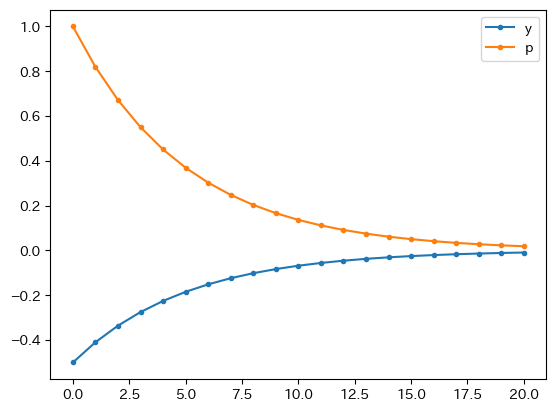

In [20]:
adas_model(p0=1).plot(marker='.')
pass

このプロットの横軸には返された`DataFrame`の行インデックスが使われているが，時系列的なプロットと考えれば良いだろう。$p_t$は初期値である１から始まっており，$y_t$の初期値は式[](eq:18-eq-y-u0)で計算した値である。このプロットから次のことが確認できる。
* 定常状態である0に両変数は近づいている。即ち，長期均衡が安定的だということである。
* 長期均衡に近づく速度は，最初は速いが，そのスピードが時間と共に落ちているのが伺える。

下のプロットは，横軸に$y_t$，縦軸に$p_t$を置いた図となる。点はAD曲線とAS曲線の交点を表している。右下がりの直線はAD曲線と等しく，AD曲線に沿ってAS曲線が下方シフトしていることになる。そういう意味では，{numref}`fig:18-adas1`で描かれている状況と同じである。

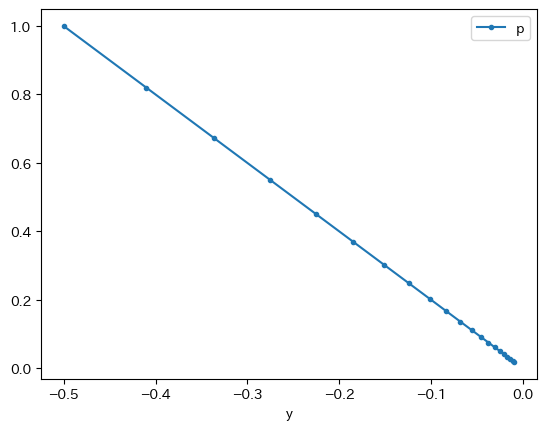

In [21]:
adas_model(p0=1).plot(x='y', y='p', marker='.')
pass

また，このプロットから長期均衡$(0,0)$に近づくにつれて，経済の動きが小刻みになっているのも確認できる。$p_t$と$y_t$の変化が小さくなり，動くスピードが遅くなっている。実は，式[](eq:18-eq-p-v0)を使うと，$p_t$が`0`に近づく変化率を簡単に計算することができる。式[](eq:18-eq-p-v0)を次のように書き直そう。

$$
p_t\text{の変化率}=
\frac{p_t}{p_{t-1}}-1=h-1=-\frac{a}{1/c+a}<0
$$

負の符号は，時間と共に$p_t$の絶対値が小さくなることを意味している（$p_t$が負の値でも同じ）。また$p_t$の変化率の絶対値は，$a$の増加関数であり，$1/c$の現象関数となっている。この結果の含意を理解するために，$a$はAS曲線の傾きであり，$1/c$はAD曲線の傾きであることを思い出そう。このことから次のことが言える。
* AS曲線の傾きが急になると，長期均衡への収束速度が速くなる。
* AD曲線の傾きが急になると，長期均衡への収束速度が遅くなる。

同様に，式[](eq:18-eq-p-v0)と[](eq:18-eq-y-u0)を使うと次の結果を導出できる。
式[](eq:18-eq-p-v0)を式[](eq:18-eq-y-u0)に代入すると

$$y_t=-cp_t$$

となる。従って，

$$
y_t\text{の変化率}=
\frac{y_t}{y_{t-1}}-1=
\frac{-cp_t}{-cp_{t-1}}-1=
\frac{p_t}{p_{t-1}}-1=
p_t\text{の変化率}
$$

$p_t$と$y_t$の変化率は同じとなることが確認できる。

下のプロットでは，$p_t$の初期値が負の場合を図示している。

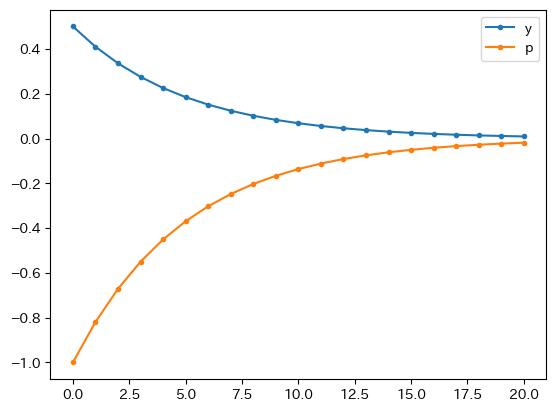

In [22]:
adas_model(p0=-1).plot(marker='.')
pass

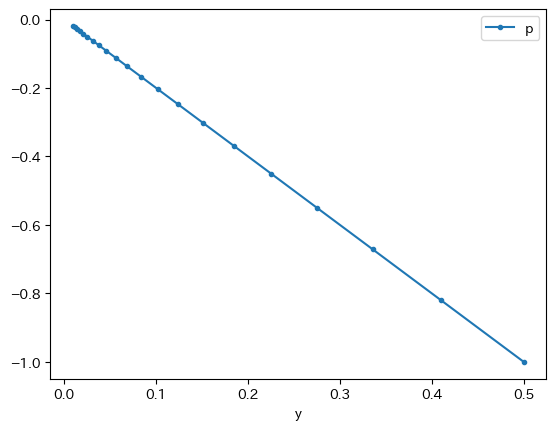

In [23]:
adas_model(p0=-1).plot(x='y', y='p', marker='.')
pass

## インパルス反応関数

インパルス反応関数とは，ある特定のショック（$u_t$もしくは$v_t$）が発生した場合，`y_t`と`p_t`がどのように変化するかを示す時系列のグラフをである。インパルス反応関数により，ショックの波及効果を可視化できる。また，後で考察する確率的シミュレーションの結果を理解する上でも有用な情報となる。

### コード

均衡式[](eq:18-as_small)と式[](eq:18-ad_small)を再掲する。

$$
p_{t}=hp_{t-1}+h\left(a u_{t}+v_{t}\right)
$$

$$
y_t = -chp_{t-1} + h(u_t-cv_t)
$$

次のコードでは，ショック項である$u_t$と$v_t$は１期間だけ変化すると仮定する。
従って，`u_std`と`v_std`は無関係となるため，コードには使っていない。
一方，`a`，`c`は上で決めた値を使うこととする。

$$
p_{t}=hp_{t-1}+h\left(a u_{t}+v_{t}\right)
$$

$$
y_t = -chp_{t-1} + h(u_t-cv_t)
$$

In [28]:
def one_period_impulse(u=0, v=0, n_after=20, a=ahat, c=chat):
    """引数
        u: AD曲線へのショックの大きさ（デフォルト：0）
        v: AS曲線へのショックの大きさ（デフォルト：0）
        n_after: ショック発生後0に戻った後の計算回数（デフォルト：20）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
    戻り値：
        y, p, u, vのDataFrame

    * 最初の３期間はショックゼロ"""

    # === hの定義 ==========
    h = 1 / ( 1+a*c )
    
    # === 初期値，forループのアップデート用変数 ==========
    p = 0       # 最初は定常状態に設定
    y = 0       # 最初は定常状態に設定
    
    # === 結果を格納するリストの作成 ==========
    # 最初の３つの要素は定常状態に設定
    y_lst = [0]*3
    p_lst = [0]*3
    u_lst = [0]*3
    v_lst = [0]*3

    # === ショック発生時 ==========
    (p, y) = ( h*p + h*( a*u+v ),     # 引数のuとvが使われる
               -c*h*p + h*( u-c*v )   # 引数のuとvが使われる
             )
        
    y_lst.append(y)
    p_lst.append(p)
    u_lst.append(u)          # 引数のuが使われる
    v_lst.append(v)          # 引数のvが使われる
        
    # === ショック後 ==========
    u, v = 0, 0     # ショックを0に戻す

    for _ in range(n_after):
        (p, y) = ( h*p + h*( a*u+v ),
                   -c*h*p + h*( u-c*v )
                 )

        y_lst.append(y)
        p_lst.append(p)
        u_lst.append(u)
        v_lst.append(v)
    
    # === 変数の辞書 ==========
    dic = {'y':y_lst, 'p':p_lst, 'u':u_lst, 'v':v_lst}
    
    # === DataFrameを返す ==========
    return pd.DataFrame(dic)

### プロット

#### 総供給ショック


0から数えて3期目に$p_t$の１％乖離を引き起こす供給ショック（$v_t=1$）を考えよう。

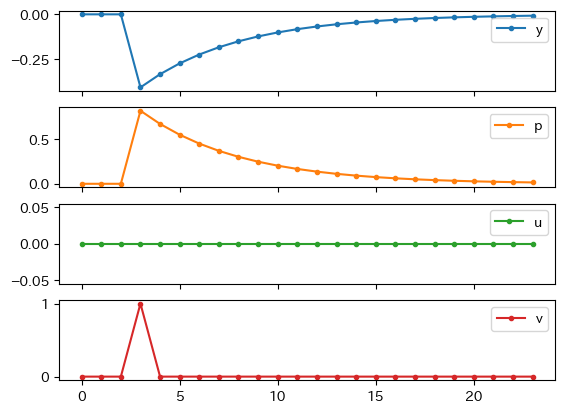

In [25]:
one_period_impulse(v=1).plot(subplots=True, marker='.')
pass

{numref}`fig:18-adas_as_shock`を使って説明しよう。
* $t=2$期以前は定常状態である0に経済は位置する。
* $t=3$期にAS曲線へのショックが発生し，AS曲線が上方シフトする（①）。経済は点Aにジャンプする。
    * $p_t$は上昇し$y_t$は減少する。
* $t=4$期では，ショックはゼロになる。しかしAS曲線は元の位置にすぐには戻らない。適応的期待により$p_3$が高かったため$p_4$も高い傾向にあるためである。従って，$p_t$は少ししか減少しない。その結果$y_t$も少ししか縮小しない。
* $t=5$期以降，AS曲線が徐々に下方シフトし，経済はAD曲線に沿って0に向かって動いていく（②）。
    * $p_t$は減少し$y_t$は増加する。

```{figure} /images/asas_as_shock.jpeg
---
scale: 35%
name: fig:18-adas_as_shock
---
総供給ショックによるインパルス反応
```

#### 総需要ショック

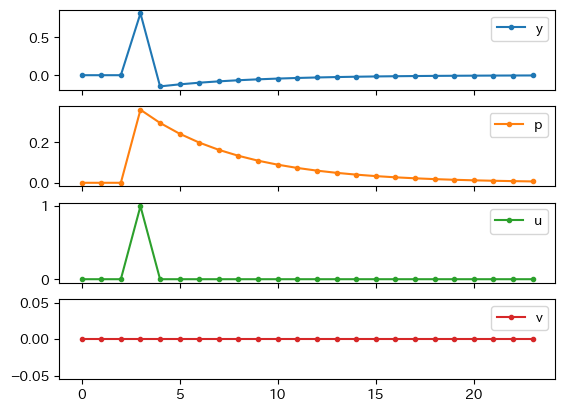

In [26]:
one_period_impulse(u=1).plot(subplots=True, marker='.')
pass

{numref}`fig:18-adas_ad_shock`を使って説明しよう。
* $t=2$期以前は定常状態である0に経済は位置する。
* $t=3$期にAD曲線へのショックが発生し，AD曲線が右シフトする（①）。経済は点Aにジャンプする。
    * $p_t$と$y_t$はともに上昇する。
* $t=4$期ではショックはゼロになり，AD曲線は元の位置に戻る（②）。一方，$p_3$が高かったため，その影響によりAS曲線は上方シフト（③），経済は点Bにジャンプする。$p_t$は減少するが高止まりする一方，$y_t$は0を下回る。
* $t=5$期以降，AS曲線が徐々に下方シフトし，経済はAD曲線に沿って0に向かって動いていく（④）。
    * $p_t$は減少し$y_t$は増加する。

```{figure} /images/asas_ad_shock.jpeg
---
scale: 35%
name: fig:18-adas_ad_shock
---
総需要ショックによるインパルス反応
```

#### 総供給・総需要ショックの同時発生

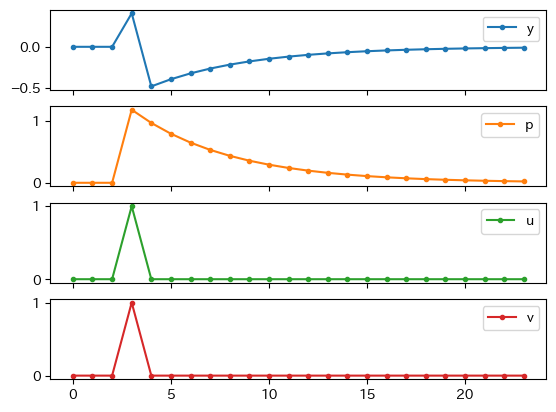

In [27]:
one_period_impulse(u=1, v=1).plot(subplots=True, marker='.')
pass

{numref}`fig:18-adas_adas_shock`を使って説明しよう。
* $t=2$期以前は定常状態である0に経済は位置する。
* $t=3$期にAD曲線とAS曲線へのショックが発生し，AD曲線は右シフトし，AS曲線は上方シフトする（①）。経済は点Aにジャンプする。
    * $p_t$と$y_t$はともに上昇する。
* $t=4$期ではショックはゼロになり，AD曲線は元の位置に戻る（②）。一方，$p_3$が高かったため，適応的期待によりAS曲線は大きくは下落せずオレンジ色の線に下方シフトし，経済は点Bに移る。
    * $p_t$は減少するが高止まりする一方，$y_t$は0を下回る。
* $t=5$期以降，AS曲線が徐々に下方シフトし，経済はAD曲線に沿って0に向かって動いていく（③）。
    * $p_t$は減少し$y_t$は増加する。

```{figure} /images/asas_adas_shock.jpeg
---
scale: 35%
name: fig:18-adas_adas_shock
---
総需要ショックと総供給ショックの同時発生によるインパルス反応
```

## 確率的シミュレーション

インパルス反応関数の分析では，ショックが１期間のみ発生した場合を考え$p_t$と$y_t$の動きを考察した。
ADASモデルの特徴を理解する上では非常に有用な分析方法である。
一方で，現実経済では大小の総需要・総供給ショックが毎期毎期連続的に発生していると考えることができるとともに，その結果としてデータに景気循環という形で現れていると解釈できる。
この節では，そのような状況を再現する確率的シミュレーションをおこなうことが一つの目的である。
もう一つの目的は，確率的シミュレーションによって生成された$p_t$と$y_t$のデータが実際の景気循環のデータをどの程度再現できるかを考察することである。データの再現性の程度によって，理論モデルとしてのADASモデルの「精度」を考えてみようということである。

ここでは総需要・総供給ショックに関して次の仮定を置く。毎期$u_t$と$v_t$は正規分布に従って発生する。

$$
u_t\sim N(0,\sigma_u^2)
\qquad\quad
v_t\sim N(0,\sigma_v^2)
$$

この仮定は次のことを意味する。
* 正規分布により，大小の様々なショックを捉えることができる。また，小さなショックと比べて大きなショックは発生し難い。
* ショックの幅は標準偏差である$\sigma_u$と$\sigma_v$で捉えることができる。
* 平均を0とすることにより，$p_t$と$y_t$の長期的な値も0に設定することができる。

### コード

$a$，$c$，$\sigma_u$，$\sigma_v$には，カリブレーションで得た値を使うこととする。

In [29]:
def stochastic_sim(n=100, a=ahat, c=chat, ustd=u_std, vstd=v_std):
    """
    引数：
        n: シミュレーションの回数（デフォルト：100）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
        ustd: 需要ショックの標準偏差（デフォルト：u_std）
        vstd: 供給ショックの標準偏差（デフォルト：v_std）
    戻り値：
        y, p, u, vのDataFrame"""
    
    # === hの定義 ==========
    h = 1/(1+a*c)
    
    # === 初期値，forループのアップデート用変数 ==========
    p = 0   # 最初は定常状態に設定
    y = 0   # 最初は定常状態に設定

    # === 結果を格納するリストの作成 ==========
    y_lst = []
    p_lst = []
    u_lst = []
    v_lst = []
    
    # === ランダム変数の「種」==========
    rng = np.random.default_rng()

    # === ループ計算 ==========
    for _ in range(n):
        # ADのショック項
        u = rng.normal(0, ustd)

        # ASのショック項
        v = rng.normal(0, vstd)
        
        (p, y) = ( h*p + h*( a*u+v ),
                   -c*h*p + h*( u-c*v )
                 )
                    
        y_lst.append(y)
        p_lst.append(p)
        u_lst.append(u)
        v_lst.append(v)
            
    # === 変数の辞書 ==========
    dic = {'y':y_lst, 'p':p_lst, 'u':u_lst, 'v':v_lst}

    # === DataFrameを返す ==========
    return pd.DataFrame(dic)

```{caution}
統計学では変数$x$が正規分布に従う場合，$x\sim N(\mu,\sigma^2)$と表す。$\mu$は平均であり，$\sigma^2$は分散を指す。一方で，上のコードの中の正規分布のランダム変数を生成するコードでは，例えば，`v=rng.normal(0, vstd)`となっており，`0`は平均であり，`vstd`は標準偏差が引数となっている。分散と標準偏差は似て異なる概念なので注意して使い分けするように。
```

### プロット

まずループ計算を100回おこなうシミュレーションの結果をプロットしてみよう。

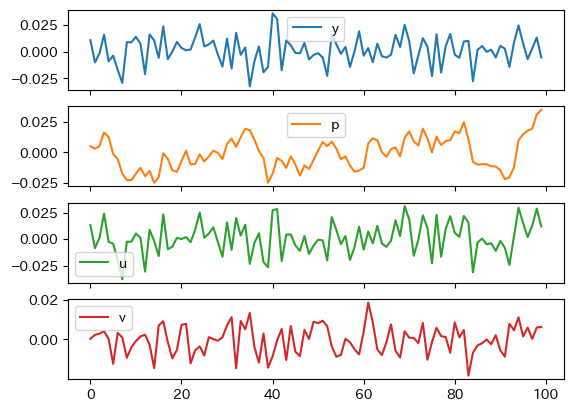

In [30]:
sim = stochastic_sim(n=100)
sim.plot(subplots=True)
pass

$u_t$と$v_t$が毎期毎期変動しており，その結果として$p_t$と$y_t$が変動していることになる。
視覚的に$p_t$は持続性が強いように見えるが，適応的期待の役割が大きいと考えられる。

このようなシミュレーションをおこなう上で注意する点がある。
ランダム変数を生成させた結果となるため，実行する度に$p_t$，$y_t$，$u_t$，$v_t$の値は異なり，プロットは異なるものとなる。従って，シミュレーションの度に平均や標準偏差は異なる値になり，特に計算回数が少ない場合に問題となる。
解決方法は簡単で，単純にループ計算の回数を大きな値にすることである。
（例えば，サイコロを$n$回投げて平均を計算するとしよう。$n=10$だと理論上の平均である3.5にはならない場合が多い。しかし，$n=100,000$の場合の平均は何回試行ても3.5に非常に近い値になる。）

では，10万回のシミュレーションをプロットしてみよう。

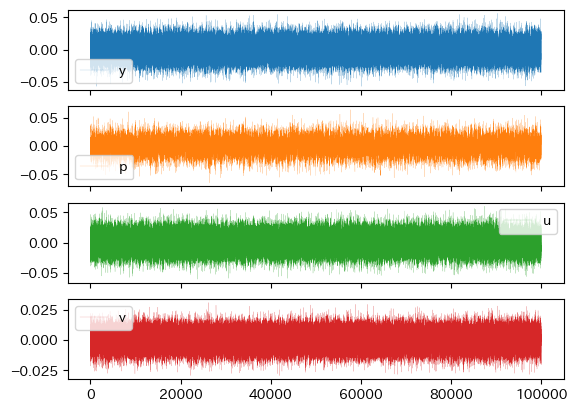

In [31]:
sim = stochastic_sim(n=100_000)
sim.plot(subplots=True, linewidth=0.1)
pass

このプロットから次の点を確認できる。
* $u_t$は概ね$(-0.05,0.05)$の間に収まっているが，$v_t$の変動幅はその1/2程である。これは`u_std`と`v_std`の値の反映と言える。
* $y_t$も概ね$(-0.05,0.05)$の間に収まっているが，$p_t$の変動幅は$y_t$よりも小さいように見える。
* ４つの変数全てにおいて0を中心に左右対称に分布している。

このシミュレーション結果を用いて統計的な特徴を計算し，実際のデータの特徴１〜３をどの程度再現できるかを考察しよう。

### GDPと価格水準の％乖離の標準偏差

**データの値（再掲）**

In [33]:
df = py4macro.data('jpn-q')
for c in ['gdp','deflator']:
    df[c+'_cycle'] = np.log(df[c]) - py4macro.trend( np.log(df[c]) )
y_std = df.loc[:,'gdp_cycle'].std()
p_std = df.loc[:,'deflator_cycle'].std()

In [34]:
print(f'GDPのトレンドからの％乖離の標準偏差：{y_std:.5f}')
print(f'デフレータのトレンドからの％乖離の標準偏差：{p_std:.5f}')

GDPのトレンドからの％乖離の標準偏差：0.01483
デフレータのトレンドからの％乖離の標準偏差：0.00749


In [36]:
from myst_nb import glue
glue("y_std_data_glued", y_std)
glue("p_std_data_glued", p_std)

0.0148330201054072

0.007490182102386834

**シミュレーションの結果**

In [35]:
for value in ['y','p']:
    print(f'{value}の標準偏差:{sim[value].std():.5f}')

yの標準偏差:0.01377
pの標準偏差:0.01425


In [36]:
y_std_sim = sim['y'].std()
p_std_sim = sim['p'].std()
glue("y_std_sim_glued", y_std_sim)
glue("p_std_sim_glued", p_std_sim)

NameError: name 'glue' is not defined

* GDPの標準偏差はデータと近い値になっている。
* 価格水準の標準偏差は大きすぎる結果となている。

### 自己相関係数

**データの値（再掲）**

In [37]:
y_autocorr = df.loc[:,'gdp_cycle'].autocorr()
p_autocorr = df.loc[:,'deflator_cycle'].autocorr()

In [38]:
print(f'GDPのトレンドからの％乖離の自己相関係数：{y_autocorr:.3f}')
print(f'デフレータのトレンドからの％乖離の自己相関係数：{p_autocorr:.3f}')

GDPのトレンドからの％乖離の自己相関係数：0.697
デフレータのトレンドからの％乖離の自己相関係数：0.830


In [39]:
glue("y_autocorr_data_glued", y_autocorr)
glue("p_autocorr_data_glued", p_autocorr)

NameError: name 'glue' is not defined

**シミュレーションの結果**

In [40]:
for value in ['y','p']:
    print(f'{value}:{sim[value].autocorr():.3f}')

y:0.039
p:0.820


In [41]:
y_autocorr_sim = sim['y'].autocorr()
p_autocorr_sim = sim['p'].autocorr()
glue("y_autocorr_sim_glued", y_autocorr_sim)
glue("p_autocorr_sim_glued", p_autocorr_sim)

NameError: name 'glue' is not defined

* `y`の自己相関係数は低すぎる。持続性が捉えられていない。
* `p`の自己相関係数はデータと近い値になっており，`p`の持続性が再現されている。

### `p`と`y`の％乖離の相関係数：同時期

**データの値（再掲）**

In [42]:
yp_corr = df.loc[:,['gdp_cycle', 'deflator_cycle']].corr().iloc[0,1]

In [43]:
print(f'GDPとデフレータの％乖離の相関係数：{yp_corr:.3f}')

GDPとデフレータの％乖離の相関係数：-0.153


In [44]:
glue("yp_corr_data_glued", yp_corr)

NameError: name 'glue' is not defined

**シミュレーションの結果**

In [45]:
yp_corr_sim = sim[['y', 'p']].corr().iloc[0,1]
glue("yp_corr_sim_glued", yp_corr_sim)

NameError: name 'glue' is not defined

In [46]:
sim[['y', 'p']].corr().iloc[0,1]

-0.11090494910826894

* 符号は合っており，数値も的外れな値ではない。

### 結果のまとめと拡張

データと`100,000`回のシミュレーション結果

|             | GDP標準偏差 | デフレータの標準偏差 | GDP自己相関係数 | デフレータの自己相関係数| GDPとデフレータの相関係数|
|-------------|-----------|--------------|-------------- |----------------|---------|
|データ        |{glue:text}`y_std_data_glued:.5f`|{glue:text}`p_std_data_glued:.5f`|{glue:text}`y_autocorr_data_glued:.5f`|{glue:text}`p_autocorr_data_glued:.5f`   | {glue:text}`yp_corr_data_glued:.5f`  |
|WNショック    |{glue:text}`y_std_sim_glued:.5f` |{glue:text}`p_std_sim_glued:.5f` |{glue:text}`y_autocorr_sim_glued:.5f`|{glue:text}`p_autocorr_sim_glued:.5f`|  {glue:text}`yp_corr_sim_glued:.5f` |
|AR(1)ショック | 0.01252     | 0.01707        |  0.649        |  0.931        |  -0.292   |

WNショックのWNはホワイト・ノイズを表しており，上のシミュレーションの結果を示している。データの数値と比べてみよう。
* GDP標準偏差の自己相関係数は概ね近い値（◯）
* デフレータの標準偏差の値は高すぎる（X）
* GDPの自己相関係数は低すぎる（X）
* デフレータの自己相関係数は近い値（◯）
* 同期のGDPと価格の相関係数は的外れではない（△）

捉えることができていないデータの特徴もある一方，全く的外れな結果ではない。
単純なAD-ASモデルにしてはまずまずの結果と言えるのではないだろうか。

次に，モデルの簡単な拡張に触れる。ホワイト・ノイズは前期のショックと今期のショックは何の関係もない独立を意味する。総需要ショックと総供給ショックは，そうなのだろうか。例えば，政府支出を考えてみよう。政府は，増税を実施すると，１四半期後に減税するような行動は取らない。少なくともある期間，政策を一貫して実施することになる。投資はどうだろうか。１四半期毎に企業は投資をコロコロと変えるような行動はしない。消費者の嗜好の変化も需要ショックとして現れるが，ファッションで今季は赤が流行り，１四半期後には青が流行るということではない。すなわち，ショックはホワイト・ノイズではなく，ある程度の**持続性**が存在すると想定できる。総供給ショックも同じように考えることができる。

この特徴を捉えるために，総需要ショックと総供給ショックに次の自己回帰モデルを想定することができる。

$$
v_t=\rho_v v_{t-1}+e^v_t,\qquad e^v_t\sim\text{WN}(0,\sigma_{ev}^2)
$$ (eq:18-v_ar1)

$$
u_t=\rho_u u_{t-1}+e^u_t,\qquad e^u_t\sim\text{WN}(0,\sigma_{eu}^2)
$$ (eq:18-u_ar1)

新たなパラメーターとして$\rho_u$，$\rho_v$，$\sigma_{eu}^2$，$\sigma_{ev}^2$の４つがあるが，これらもデータを使って次のように推定することが可能である。
1. 式[](eq:18-vt)の$\hat{v}$を使い，式[](eq:18-v_ar1)を推定式として$\hat{\rho}_v$を推定する。またその残差の標準偏差を$\sigma_{ev}$とする。
1. 式[](eq:18-ut)の$\hat{u}$を使い，式[](eq:18-u_ar1)を推定式として$\hat{\rho}_u$を推定する。またその残差の標準偏差を$\sigma_{eu}$とする。

このように計算すると次の値となる。
* $\hat{\rho}_u=0.6884968624035948$
* $\hat{\rho}_v=0.31284420357447135$
* $\hat{\sigma}_{eu}=0.010415370807183315$
* $\hat{\sigma}_{ev}=0.006036417181315$

これらの値を使い`100,000`回シミュレーションした結果が上の表の「AR(1)ショック」に示されている。次のように結果をまとめることができる。
* GDP標準偏差の自己相関係数は少し低い（△）
* デフレータの標準偏差の値は高すぎる（X）
* GDPの自己相関係数は概ね近い値（◯）
* デフレータの自己相関係数は若干高い値（△）
* 同期のGDPと価格の相関係数は概ね近い値（◯）

ホワイト・ノイズの場合と比べると，AR(1)のケースが若干ではあるが再現性が向上したようにも見える。例えば，GDPの自己相関係数は格段にデータの値に近づいた。一方で，デフレーターの標準偏差の再現性はホワイト・ノイズの場合よりも悪くなっている。AR(1)のショックを導入しても再現性の著しい向上とは言えないだろう。

````{note}
ここではカリブレーションに最小二乗法を使いパラメータを推定したが、次の論文では状態空間モデルと呼ばれる手法を用いて推定をおこない、
確率的シミュレーションを含む様々な分析を行っている。論文で使った`Python`コードも公開しているので、参考にしてはどうだろう。
```
「需要ショックと供給ショックについて：AD-ASモデルの状態空間分析」、『国民経済雑誌』第227巻第5号(2023年9月) 頁1〜14
```
````

### ADASモデルの評価

ADASモデルは，経済を理解する上では非常に有用だが，データの一部の特徴の説明力に欠ける。
どう評価すれば良いだろうか。

経済学研究で用いる推論方法を考えてみよう。
帰納的推論（inductive inference）とは，真のモデルが存在するという前提の下でデータを使い推定するモデルの蓋然性を検討する手法である。
典型的な例として，計量経済分析が当てはまる。
推定されたモデルは，帰納的推論の**アウトプット**ということになる。

```{figure} /images/inductive.png
---
scale: 35%
name: fig:18-inductive
---
帰納的推論
```

一方，演繹的推論（deductive inference）では，モデルは**インプット**になる。
モデルを「装置」として使い，理論の含意に関して推論しようということである。
例えば，ADASモデルで比較静学をおこない，外生変数の定性的な効果を検討する場合が当てはまる。
政府支出が増加すると実質利子率は上昇するとい結果は，ADASモデルを使った演繹的推論の結果である。
しかし，経済モデルは複雑な経済を抽象化した考え方に過ぎず，ADASモデルを含めてどのような経済モデルであっても複雑な経済の全ての側面を捉えることはできない「間違った」モデルである。
また，この章の目的はADASモデルが真のモデルかどうかを判断しようということではない。
従って，データの特徴の一部を説明できないのは，単にADASモデルの限界を表していると解釈できる。

```{figure} /images/deductive.png
---
scale: 35%
name: fig:18-deductive
---
演繹的推論
```

では，ADASモデルのどこに有用性があるのだろうか。
カリブレーションを説明する際，手作りの体重計の例を使ったがもう一度考えみよう。
カリブレーション後，60kg以上の体重は誤差が大きく使いものにならないが，60kg未満であれば誤差は許容範囲だとしてみよう。
この場合，「普通の小学生やそれより幼い子どもの体重を測る」ことが目的であれば，手作り体重計の成功と考えることができる。
要するに，完璧な「装置」でなくとも，目的に沿ったものであれば十分だということだ。
「完璧でなくても良い」という考え方は，地図の有用性を考えれば直ぐに理解できるのではないだろうか。
地図は，実際の距離を縮尺にしており，多くの詳細が省かれている。
三宮のレストランを探す場合，世界地図は使いものにならない。
しかし，石油を運ぶタンカーの運航や宇宙衛星を落下させる際には重要な役割を果たす（政治的な目的にも有用だという主張もある）。
経済モデルは地図のようなものであり，AD-ASモデルは不完全だが，ある目的のためであれば有用になり得るということだ。

このような演繹的推論に基づき，再現性の精度には多少欠けることも念頭に，次のセクションではADASモデルを「装置」として使い**定量的**な問を検討する。

## 定量的な問い

> GDPと価格水準の長期トレンドからの乖離（％）の変動は，何パーセントが需要ショックにより引き起こされ，何パーセントが供給ショックに起因するのか？

この問を検討するには，定性的な比較静学では不可能であり，定量的なアプローチが要求される。
ここでは分散分解分析をおこなう。

### $p_t$に対する影響：分散分解分析

均衡式[](eq:18-eq-p)を再掲する。

$$p_{t}=hp_{t-1} + e_{pt},\qquad\qquad e_{pt}=ahu_{t}+hv_{t}$$

$p_{t}$の分散$\text{Var}(p_{t})$を次のように書き換えよう。
（分散と共分散の性質については[付録Ａ](sec:18-appendix_A)を参照）

\begin{align}
\text{Var}(p_{t})
&=\text{Var}(hp_{t-1} + e_{pt})\qquad\cdots\cdots [1]\\
&=\text{Var}(hp_{t-1})+\text{Var}(e_{pt})+2\text{Cov}(hp_{t-1},e_{pt})\qquad\cdots [2]\\
&=\text{Var}(hp_{t-1})+\text{Var}(e_{pt})\qquad\cdots [3]\\
&=h^2\text{Var}(p_{t-1})+\text{Var}(e_{pt})\qquad\cdots [4]\\
&=h^2\text{Var}(p_{t})+\text{Var}(e_{pt})\qquad\cdots [5]\\
(1-h^2)\text{Var}(p_{t})
&=\text{Var}(e_{pt})\qquad\cdots\cdots\cdots [6]\\
\text{Var}(p_{t})
&=\frac{\text{Var}(e_{pt})}{1-h^2}\qquad\cdots\cdots\cdots [7]
\end{align} (eq:18-eq-varp)

* [1]：$p_t$に式[](eq:18-eq-ppp)を代入。
* [2]：右辺を展開。
* [3]：$p_{t-1}$と$e_{pt}$の間で時間がズレているため$\text{Cov}(hp_{t-1},e_{pt})=0$。
* [4]：定数$h$を$\text{Var}()$の外に出す。
* [5]：$t$が十分に大きい場合（$t\rightarrow\infty$）は$\text{Var}(p_{t})=\text{Var}(p_{t-1})$。
* [6]：$h^2\text{Var}(p_{t})$を左辺い移動。
* [7]：両辺を$(1-h^2)$で除する。

式[](eq:18-eq-varp)は，$p_t$の分散は$e_{pt}$の分散に依存していることを示している。
$e_{pt}$は需要ショックと供給ショックの両方から構成されているため，それを分解する必要がある。
$e_{pt}$は次の式で与えられる。

$$
e_{pt}=ahu_{t}+hv_{t}
$$ (eq:18-eq-ept)

$e_{pt}$の分散を次のように計算する。

\begin{align}
\text{Var}(e_{pt})
&=\text{Var}(ahu_{t}+hv_{t})\qquad\cdots\cdots [1]\\
&=\text{Var}(ahu_{t})+\text{Var}(hv_{t})\qquad\cdots [2]\\
&=(ah)^2\text{Var}(u_{t})+h^2\text{Var}(v_{t})\qquad\cdots [3]
\end{align} (eq:18-eq-varep)

* [1]：$e_{pt}$に式[](eq:18-eq-ept)を代入。
* [2]：右辺を展開。
* [3]：定数$ah$と$h$を$\text{Var}()$の外に出す。

最後に式[](eq:18-eq-varep)を式[](eq:18-eq-varp)に代入し，次のように整理する。

\begin{align}
\text{Var}(p_{t})
&=\frac{(ah)^2\text{Var}(u_{t})+h^2\text{Var}(v_{t})}{1-h^2}\\
&=\frac{(ah)^2}{1-h^2}\text{Var}(u_{t})
+\frac{h^2}{1-h^2}\text{Var}(v_{t})\\
&=\left(\text{需要ショックに起因する変動}\right)+\left(\text{供給ショックに起因する変動}\right)
\end{align} (eq:18-eq-varp2)

＜この式の解釈＞
* 左辺は$p_t$の総変動であり，それを需要ショック（$u_t$）と供給ショック（$v_t$）に分解したのが右辺となる。
* 右辺の解釈
    * まず総需要・総供給ショックが全くない場合を考えてみよう。$u_t=v_t=0$となるため$\text{Var}(u_{t})=\text{Var}(v_{t})=0$となり，右辺は`0`であり$p_t$は変動しない。
    * 次に，$u_t=0$に固定し，供給ショック$v_{t}$だけを変動させてみよう。需要曲線は動かず，供給曲線だけが上下にシフトする場合である。$p_t$の変動は$v_t$の変動にのみ依存し，$\text{Var}(p_{t})=\dfrac{h^2}{1-h^2}\text{Var}(v_{t})$となる。同様に，$v_t=0$に固定し，需要ショック$u_{t}$だけを変動させてみよう。供給曲線を一定として需要曲線だけが左右にシフトする。$p_t$の変動は$u_t$の変動にのみ依存し，$\text{Var}(p_{t})=\dfrac{(ah)^2}{1-h^2}\text{Var}(u_{t})$となる。
    * 最後に，$u_t$と$v_t$を同時に変動させると，$p_t$の総変動は式[](eq:18-eq-varp2)の右辺の２つの項から構成されることになる。第１項が需要ショックに起因する$p_t$の変動であり，第２項が供給ショックにより発生した$p_t$の変動となる。そういう意味で，$p_t$の総変動は需要ショックと供給ショックに分解されたと解釈できる。
    * $p_t$の総変動の大きさ（水準）を決定する上で，$h$ が重要な役割を果たしている。$h$はは約`0.8`であり$p_t$の高い持続性を意味する。持続性が高い場合，一旦総供給曲線が定常状態の位置から離れると元の位置に戻るには時間が掛かることになる。即ち，定常状態から離れた状態が長くなる。そのような状況下で，更にショックが発生すると，定常状態から更に乖離する結果につながることになり，変動が増幅されることになる。その効果が$\dfrac{h^2}{1-h^2}$で捉えられている。

需要ショックと供給ショックに起因する$p_t$の変動の**割合**を計算するために，式[](eq:18-eq-varp2)の両辺を$\text{Var}(p_{t})$で割ると次式となる。

\begin{align}
1&=
\frac{(ah)^2}{1-h^2}\cdot\frac{\text{Var}(u_{t})}{\text{Var}(p_{t})}
+\frac{h^2}{1-h^2}\cdot\frac{\text{Var}(v_{t})}{\text{Var}(p_{t})}
\end{align}

この結果を使い次のように定義する。

$$
\left[
\begin{split}
&p_t\text{の変動に対する}\\
&u_t\text{(需要ショック)}\\
&\text{の寄与度}
\end{split}
\right]
=\frac{(ah)^2}{1-h^2}\cdot\frac{\text{Var}(u_{t})}{\text{Var}(p_{t})}
=\frac{a^2\text{Var}(u_{t})}{a^2\text{Var}(u_{t})+\text{Var}(v_{t})}
\tag{u-p}
$$

$$
\left[
\begin{split}
&p_t\text{の変動に対する}\\
&v_t\text{(供給ショック)}\\
&\text{の寄与度}
\end{split}
\right]
=\frac{h^2}{1-h^2}\cdot\frac{\text{Var}(v_{t})}{\text{Var}(p_{t})}
=\frac{\text{Var}(v_{t})}{a^2\text{Var}(u_{t})+\text{Var}(v_{t})}
\tag{v-p}
$$

それぞれの式の最後の等号には式[](eq:18-eq-varep2)を$\text{Var}(p_{t})$に代入して整理している。
式[](eq:18-eq-varp2)の$\dfrac{h^2}{1-h^2}$は$p_t$の持続性の影響を捉えていると説明したが，その影響は式(u-p)と(v-p)を計算する上でキャンセルされており，ショックの相対的な寄与度はもっぱら供給曲線の傾きである$a$に影響されることが分かる。

### $y_t$に対する影響：分散分解分析

同様の手法を使い$y_t$の総変動の分散分解分析をおこなう。均衡式[](eq:18-eq-y)を再掲する。

$$
y_t = -chp_{t-1} + e_{yt},
\qquad
e_{yt}=h(u_t-cv_t)
$$ (eq:18-eq-yyy)

$y_{t}$の分散$\text{Var}(y_{t})$を次のように書き換えよう。

\begin{align}
\text{Var}(y_{t})
&=\text{Var}(-chp_{t-1} + e_{yt})\qquad\cdots\cdots [1]\\
&=\text{Var}(-chp_{t-1})+\text{Var}(e_{yt})+2\text{Cov}(-chp_{t-1},e_{yt})\qquad\cdots [2]\\
&=\text{Var}(-chp_{t-1})+\text{Var}(e_{yt})\qquad\cdots [3]\\
&=(-ch)^2\text{Var}(p_{t-1})+\text{Var}(e_{yt})\qquad\cdots [4]\\
&=(ch)^2\text{Var}(p_{t})+\text{Var}(e_{yt})\qquad\cdots [5]\\
\end{align} (eq:18-eq-vary)

* [1]：$y_t$に式[](eq:18-eq-yyy)を代入。
* [2]：右辺を展開。
* [3]：$p_{t-1}$と$e_{yt}$の間で時間がズレているため$\text{Cov}(-chp_{t-1},e_{yt})=0$。
* [4]：定数$(-ch)$を$\text{Var}()$の外に出す。
* [5]：$t$が十分に大きい場合（$t\rightarrow\infty$）は$\text{Var}(p_{t})=\text{Var}(p_{t-1})$。

式[](eq:18-eq-vary)は，$p_t$の分散と$e_{yt}$の分散に依存していることを示している。
$p_t$の分散は式[](eq:18-eq-varep2)で与えられているが，$e_{yt}$は需要ショックと供給ショックの両方から構成されているため，それを分解する必要がある。
$e_{pt}$を分解した同じ方法で$e_{yt}$を分解しよう。

$e_{yt}$は次の式で与えられる。

$$
e_{yt}=hu_t-chv_t
$$ (eq:18-eq-eyt)

$e_{yt}$の分散を次のように計算する。

\begin{align}
\text{Var}(e_{yt})
&=\text{Var}(hu_t-chv_t)\qquad\cdots\cdots [1]\\
&=\text{Var}(hu_t)+\text{Var}(-chv_t)\qquad\cdots [2]\\
&=h^2\text{Var}(u_{t})+(-ch)^2\text{Var}(v_{t})\qquad\cdots [3]\\
&=h^2\text{Var}(u_{t})+(ch)^2\text{Var}(v_{t})\qquad\cdots [4]
\end{align} (eq:18-eq-varyp)

* [1]：$e_{yt}$に式[](eq:18-eq-eyt)を代入。
* [2]：右辺を展開。
* [3]：定数$h$と$(-ch)$を$\text{Var}()$の外に出す。
* [4]：$(-ch)^2=(ch)^2$

最後に，式[](eq:18-eq-varyp)と式[](eq:18-eq-varp2)を式[](eq:18-eq-vary)に代入すると次式を導出できる（詳細は[付録Ｂ](sec:18-appendix_B)を参照）。

\begin{align}
\text{Var}(y_{t})
&=\frac{h^2}{1-h^2}2ach\text{Var}(u_{t})
+\frac{h^2}{1-h^2}c^2\text{Var}(v_{t})\\
&=\left(\text{需要ショックに起因する変動}\right)+\left(\text{供給ショックに起因する変動}\right)
\end{align} (eq:18-eq-vary2)

＜この式の解釈＞
* 左辺は$y_t$の総変動であり，それを需要ショック（$u_t$）と供給ショック（$v_t$）に分解したのが右辺となる。
* $p_t$の総変動の大きさ（水準）を決定する上で，$h$ が重要な役割を果たしている。$h$はは約`0.8`であり$p_t$の高い持続性を意味する。持続性が高い場合，一旦総供給曲線が定常状態の位置から離れると元の位置に戻るには時間が掛かることになる。即ち，定常状態から離れた状態が長くなる。そのような状況下で，更にショックが発生すると，定常状態から更に乖離する結果につながることになり，変動が増幅されることになる。その効果が$\dfrac{h^2}{1-h^2}$で捉えられている。

需要ショックと供給ショックに起因する$y_t$の変動の**割合**を計算するために，式[](eq:18-eq-vary2)の両辺を$\text{Var}(y_{t})$で割ると次式となる。

\begin{align}
1
&=\frac{h^2}{1-h^2}2ach\frac{\text{Var}(u_{t})}{\text{Var}(y_{t})}
+\frac{h^2}{1-h^2}c^2\frac{\text{Var}(v_{t})}{\text{Var}(y_{t})}\\
\end{align}

この結果を使い次のように定義する。

$$
\left[
\begin{split}
&y_t\text{の変動に対する}\\
&u_t\text{(需要ショック)}\\
&\text{の寄与度}
\end{split}
\right]
=\frac{h^2}{1-h^2}2ach\frac{\text{Var}(u_{t})}{\text{Var}(y_{t})}
=\frac{2a\text{Var}(u_{t})}{2a\text{Var}(u_{t})+c(1+ac)\text{Var}(v_{t})}
\tag{u-y}
$$

$$
\left[
\begin{split}
&p_t\text{の変動に対する}\\
&v_t\text{(供給ショック)}\\
&\text{の寄与度}
\end{split}
\right]
=\frac{h^2}{1-h^2}c^2\frac{\text{Var}(v_{t})}{\text{Var}(y_{t})}
=\frac{c(1+ac)\text{Var}(v_{t})}{2a\text{Var}(u_{t})+c(1+ac)\text{Var}(v_{t})}\\
\tag{v-y}
$$

それぞれの式の最後の等号には式[](eq:18-eq-vary2)を$\text{Var}(y_{t})$に代入して整理している（詳細は[付録Ｃ](sec:18-appendix_c)を参照）。式[](eq:18-eq-vary2)の$\dfrac{h^2}{1-h^2}$は$p_t$の持続性の影響を捉えていると説明したが，その影響は式(u-y)と(v-y)を計算する上でキャンセルされている。

### 産出量水準の％乖離

#### 計算結果

変数の推定値を使い，式(u-y)と(v-y)を計算してみよう。

In [61]:
# 式(u-y)の分子
numerator_y = 2 * ahat * u_std**2

# 式(u-y)の分母
denominator_y = 2 * ahat * u_std**2 + chat * (1+ahat*chat) * v_std**2

ad_shock_on_y = numerator_y / denominator_y
print(f'GDPの％乖離の{100*ad_shock_on_y:.1f}％は総需要ショックに起因する。'  )

GDPの％乖離の84.8％は総需要ショックに起因する。


In [59]:
print(f'GDPの％乖離の{100*(1-ad_shock_on_y):.1f}％は総供給ショックに起因する。'  )

GDPの％乖離の15.2％は総供給ショックに起因する。


#### 解釈

GDPの％乖離に対しては総需要ショックが相対的に大きな影響を及ぼしていることがわかる。
3つ理由がある。
まず第一に，需要ショック（$u_t$）の変動は供給ショック（$v_t$）よりも大きいことである。

In [65]:
u_std**2 / v_std**2

3.877351543861993

$\text{Var}(u_{t})$は$\text{Var}(v_{t})$の約`3.9`倍となっている。

第二に，総需要曲線の傾きが大きいためである。
総需要曲線の傾きは$1/c$で与えられ，$c$が大きくなるとより緩やかな傾きとなる。
実際，式(u-y)は $c$ の減少関数であり，式(u-p)は $c$ の増加関数である。
この関係を理解するために，{numref}`fig:18-y-uv`では，AD曲線の傾きが急な場合と緩やかな場合の２つのケースを示している。
* $1/c$ が小さいケース（$c$が大きい）：
    * 総需要曲線の傾きは緩やかになる。
    * 総供給曲線が動くと$y_t$は大きく動くが，$p_t$は大きく動かない。
* $1/c$ が大きいケース（$c$が小さい）：
    * 総需要曲線の傾きは急になる。
    * 総供給曲線が動くと$y_t$の動きは小さくなる一方，$p_t$は大きく動くことになる。

$1/c$ の値は`1`よりも大きく，$1/c$ が大きいケースが当てはまる。この場合，$y_t$に対する総供給ショックのインパクトは小さな値となり，相対的に総需要ショックの寄与度が高くなっていると考えられる。また，需要ショックは総需要曲線を左右にシフトするが，総需要曲線の傾きが大きい場合，そのインパクトはより大きくなる。

```{figure} /images/adas-y-uv.jpeg
---
scale: 35%
name: fig:18-y-uv
---
総需要曲線の傾きが大きい場合，GDPの％乖離の変動における総供給ショックの影響は小さくなる。
```

第三に，総供給曲線の傾きが緩やかなためである。総供給曲線の傾きは $a$ で与えられ，低い $a$ は総供給曲線をより緩やかにする
式(u-y)は $a$ の増加関数であり，式(u-p)は $c$ の減少関数であることは簡単に確認できる。
{numref}`fig:18-p-uv`では，AS曲線の傾きが急な場合と緩やかな場合の２つのケースを示している。
* $a$ が小さい場合，総供給曲線の傾きは緩やかになる。その場合，需要曲線が動くと$y_t$は大きく動くが，$p_t$は大きく動かない。
* $a$ が大きい場合，総供給曲線の傾きは急になる。その場合，需要曲線が動くと$y_t$の動きは小さくなる一方，$p_t$は大きく動くことになる。

$a$ の値は`1`よりも小さく，$a$ が小さいケースが当てはまる。この場合，$p_t$に対する総需要ショックのインパクトは小さな値となり，相対的に総供給ショックの寄与度が高くなっていると考えられる。

```{figure} /images/adas-p-uv.jpeg
---
scale: 35%
name: fig:18-p-uv
---
物価水準の％乖離の変動において総供給ショックの影響が大きい理由
```

### 価格水準の％乖離

#### 計算結果

変数の推定値を使い，式(u-p)と(v-p)を計算してみよう。

In [66]:
# 式(u-p)の分子
numerator_p = ahat**2 * u_std**2
# 式(*p)の分母
denominator_p = ahat**2 * u_std**2 + v_std**2

ad_shock_on_p = numerator_p / denominator_p
print(f'価格水準の％乖離の{100*ad_shock_on_p:.1f}％は需要ショックに起因する。'  )

価格水準の％乖離の42.9％は需要ショックに起因する。


In [67]:
print(f'価格水準の％乖離の{100*(1-ad_shock_on_p):.1f}％は供給ショックに起因する。'  )

価格水準の％乖離の57.1％は供給ショックに起因する。


#### 解釈

価格水準の％乖離に対しては総需要ショックと総供給ショックが概ね同程度の影響を及ぼしていることがわかる。
総需要ショックの変動は総供給ショックの`4`倍近くあることを思い出そう。
この大きな違いを減衰させているのが，総需要曲線の比較的に大きな傾きであり，総供給曲線の比較的に小さな傾きである。

## まとめ

GDPと価格水準のトレンドからの％乖離のプロットを再掲する。

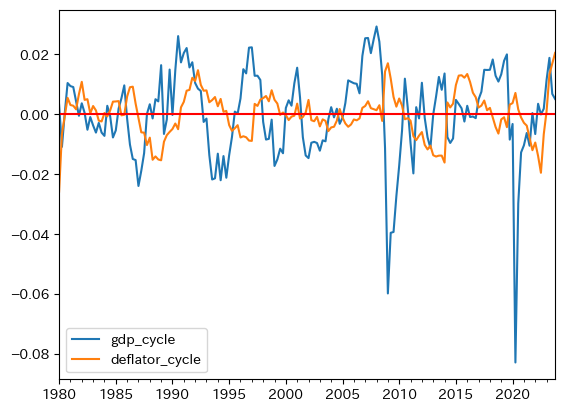

In [18]:
ax_ = df.plot(y=['gdp_cycle','deflator_cycle'])
ax_.axhline(0, color='red')
pass

このプロットを眺めることにより，総需要ショックと総供給ショックがどれだけ景気循環に影響を及ぼしているかが分かるだろうか。もちろん否である。ADASモデルを「装置」として用いて，「スイッチ」を調整することにより，結果が数字として現れてくることになる。
「調整済み装置」があってこその分析結果であり，体重計がないと体重を測れないことと同じである。

体重計の例をもう一度考えてみよう。
今度は，AさんとBさんが作る体重計である。
Aさんの体重計は単純な装置だが，一方，Bさんの技術は高く，設計図は洗練され使う材料もより質が高いとしてみよう。
その差は精度の違いとして現れることになるだろう。
マクロ経済モデルも同じである。
ADASモデルは，研究や政策議論で使われるモデルと比べると単純なモデルであり，それが故に定量的な問に対しての答えも精度が低いものとならざるを得ない。
大学院で学ぶDSGEモデルや構造VARモデルなどはより洗練された「装置」であり，ADASモデルよりも精度が高い結果を返すことになるだろう。

(sec:18-appendix_A)=
## 付録Ａ：分散と共分散の性質

$X$，$Y$，$Z$，$W$をランダム変数，$a$，$b$，$c$，$d$を定数とする。
分散に関して次の結果が成立する。

$$
\begin{align*}
\text{Var}(k)&=0\\
\text{Var}(X+k)&=\text{Var}(X)\\
\text{Var}(aX)&=a^2\text{Var}(X)\\
\text{Var}(aX\pm bY)&=a^2\text{Var}(X)+b^2\text{Var}(Y)\pm 2ab\text{Cov}(X,Y) \\
\end{align*}
$$

共分散に関して次の結果が成立する。

$$
\begin{align*}
\text{Cov}(X,a)&=0\\
\text{Cov}(X,X)&=\text{Var}(X)\\
\text{Cov}(aX,bY)&=ab\text{Cov}(Y,X)\\
\text{Cov}(X+a,Y+b)&=\text{Cov}(Y,X)\\
\text{Cov}(aX+bY,cZ+dW)&=ac\text{Cov}(X,Z)+ad\text{Cov}(X,W)+bc\text{Cov}(Y,Z)+bd\text{Cov}(Y,W)
\end{align*}
$$

(sec:18-appendix_B)=
## 付録Ｂ：式[](eq:18-eq-vary2)の導出

式[](eq:18-eq-varp2)と式[](eq:18-eq-varyp)を式[](eq:18-eq-vary)に代入し整理する。

\begin{align}
\text{Var}(y_{t})
&=(ch)^2\text{Var}(p_{t})+\text{Var}(e_{yt})\\
&=(ch)^2\left[
    \frac{(ah)^2}{1-h^2}\text{Var}(u_{t})
    +\frac{h^2}{1-h^2}\text{Var}(v_{t})
\right]
+h^2\text{Var}(u_{t})+(ch)^2\text{Var}(v_{t})\\
&=\left[(ch)^2
    \frac{(ah)^2}{1-h^2}+h^2
\right]\text{Var}(u_{t})
+\left[
    (ch)^2\frac{h^2}{1-h^2}+(ch)^2
\right]\text{Var}(v_{t})\\
&=\frac{h^2}{1-h^2}\left[
    (ach)^2+1-h^2
\right]\text{Var}(u_{t})
+\frac{(ch)^2}{1-h^2}\left[h^2+1-h^2\right]\text{Var}(v_{t})\\
&=\frac{h^2}{1-h^2}\left[
    1+(ach)^2-h^2
\right]\text{Var}(u_{t})
+\frac{(ch)^2}{1-h^2}\text{Var}(v_{t})
\end{align}

ここで

\begin{align}
1+(ach)^2-h^2
&=1+h^2[(ac)^2-1]=1+\frac{(ac)^2-1}{(1+ac)^2}\\
&=1+\frac{(ac+1)(ac-1)}{(1+ac)^2}=1+\frac{ac-1}{1+ac}\\
&=\frac{1+ac+ac-1}{1+ac}=\frac{2ac}{1+ac}\\
&=2ach
\end{align}

この式を上の式に代入すると式[](eq:18-eq-vary2)となる。

(sec:18-appendix_c)=
## 付録Ｂ：式(u-y)と(v-y)の導出

式(u-y)に式[](eq:18-eq-vary2)を代入して整理する。

\begin{align}
\left[
\begin{split}
&y_t\text{の変動に対する}\\
&u_t\text{(需要ショック)}\\
&\text{の寄与度}
\end{split}
\right]
&=\frac{h^2}{1-h^2}2ach\frac{\text{Var}(u_{t})}{\text{Var}(y_{t})}\\
&=\dfrac{h^2}{1-h^2}2ach\frac{\text{Var}(u_{t})}{
\left(
\dfrac{h^2}{1-h^2}2ach\text{Var}(u_{t})
+\dfrac{h^2}{1-h^2}c^2\text{Var}(v_{t})
\right)
}\\
&=\frac{2ach\text{Var}(u_{t})}{
2ach\text{Var}(u_{t})
+c^2\text{Var}(v_{t})
}
=\frac{2a\text{Var}(u_{t})}{
2a\text{Var}(u_{t})
+(c/h)\text{Var}(v_{t})
}\\
&=\frac{2a\text{Var}(u_{t})}{2a\text{Var}(u_{t})+c(1+ac)\text{Var}(v_{t})}\\
\tag{u-y}
\end{align}


同様に式(v-y)に式[](eq:18-eq-vary2)を代入して整理する。

\begin{align}
\left[
\begin{split}
&p_t\text{の変動に対する}\\
&v_t\text{(供給ショック)}\\
&\text{の寄与度}
\end{split}
\right]
&=\frac{h^2}{1-h^2}c^2\frac{\text{Var}(v_{t})}{\text{Var}(y_{t})}\\
&=\frac{h^2}{1-h^2}c^2\frac{\text{Var}(v_{t})}{
\left(
\dfrac{h^2}{1-h^2}2ach\text{Var}(u_{t})
+\dfrac{h^2}{1-h^2}c^2\text{Var}(v_{t})
\right)
}\\
&=\frac{c^2\text{Var}(v_{t})}{
2ach\text{Var}(u_{t})
+c^2\text{Var}(v_{t})
}
=\frac{(c/h)\text{Var}(v_{t})}{
2a\text{Var}(u_{t})
+(c/h)\text{Var}(v_{t})
}\\
&=\frac{c(1+ac)\text{Var}(v_{t})}{2a\text{Var}(u_{t})+c(1+ac)\text{Var}(v_{t})}\\
\end{align}